In [57]:
import os
import csv
import codecs
from os import path
import pandas as pd
import networkx as nx
import re
# !pip install git+https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git
from nltk.corpus import stopwords
from tqdm import tqdm
import fasttext as ft
import os
from collections import Counter
import pickle
import scipy.sparse as sp
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import time
import argparse
import torch.optim as optim
from sklearn.model_selection import train_test_split

import spacy

In [2]:
nlp = spacy.load('fr_core_news_md')

lid_model = ft.load_model("lid.176.ftz")

### text preprocessing and vocabulary extraction

In [362]:
french_stopwords = stopwords.words('french')
other = ['être', 'avoir', 'tout', 'site', 'recherche', 'français', 'rechercher', 'accueil', 'plus', 'faire']
french_stopwords += other
min_occurences = 20
min_characters = 2
max_characters = 12


# Data Paths
data_path = 'pickles/'
files_path = 'text/text/'


## ------------------------------ File Processing --------------------------- ##


def process_file(file):
    """
    Function to process a single file.

    ---
    Parameters:
        file : str
                File name in the Data Folder.

    ---
    Results:
        my_data : dict
                Dictionnary containing the number of occurences of each word in
                the document.
    """

    try:
        with open(files_path+data_path+file+'.pickle', 'rb') as handle:
            my_data = pickle.load(handle)
    
    except:
        f = open(files_path + file, "r", encoding="utf-8")
        l = []
        try:
            for x in f:
                x = re.sub(r'[^\w'+"'’ "+']', "",x) #removing all non-alphanumeric characters except apostrophes
                x = x.lower()
                x = x.replace('\n', "")
                x = re.sub(' +', ' ', x) # removing duplicate spaces
                x = x.strip()
                # checking if line is not empty and is in french
                if (x != '' and lid_model.predict(x)[0][0]=='__label__fr'):
                    # lemmatization using spacy
                    doc = nlp(x)
                    tokens = []
                    for token in doc:
                        tokens.append(token.lemma_)
                    x = ' '.join(tokens)
                    l.append(x)
        except:
            pass
        my_data = {}
        for lines in l :
            my_elements = lines.split(' ')

            for element in my_elements:
                if element.isalpha():
                    if not element in french_stopwords: # removing stopwords
                        if element in my_data.keys():   # checking if entry exists in file vocabulary
                            my_data[element] += 1

                        else:
                            my_data[element] = 1


        my_data = dict(filter(lambda elem: lid_model.predict(elem[0])[0][0]=='__label__fr', \
                                                        my_data.items()))   
        my_data = dict(filter(lambda elem: (len(elem[0]) > min_characters) and (len(elem[0]) < max_characters), \
                                                        my_data.items()))
        with open(files_path+data_path+file+'.pickle', 'wb') as handle:
            pickle.dump(my_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
    
    return my_data

## ------------------------------ Vocab Extract ----------------------------- ##


def get_vocab(files=[], pkl = True):
    """
    Function to extract the vocabulary contained in the train data

    ---
    Parameters:
        train_data : DataFrame Pandas
                Training DataFrame containg the names of the training files
                to be used

    ---
    Results:
        my_data : dict
                Dictionnary containing the number of occurences of each word in
                all the documents
    """
    
    if not pkl:
        vocab = {}
        for file in tqdm(files):

            vocab_file = process_file(str(file))
            vocab = dict(Counter(vocab) + Counter(vocab_file))
            
        vocab = dict(filter(lambda elem: elem[1] >= min_occurences, \
                                                    vocab.items()))
        print(len(vocab))
        with open('vocab.pickle', 'wb') as handle:
            pickle.dump(vocab, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
    else:
        vocab = {}
        try:
            with open('vocab.pickle', 'rb') as handle:
                vocab = pickle.load(handle)
        except:
            print('no vocabulary found !')
    vocab = {k: v for k, v in sorted(vocab.items(), reverse=True,key=lambda item: item[1])}
            
    for key in other:
        vocab.pop(key, None)
    return vocab

In [4]:
file_vocab = process_file(file='0')
file_vocab

{'école': 3,
 'porte': 2,
 'ouvert': 2,
 'plaquette': 1,
 'ouverture': 1,
 'web': 1,
 'étudiant': 3,
 'carrière': 1,
 'laboratoire': 1,
 'emploi': 1,
 'taxe': 1,
 'contenu': 1,
 'supérieur': 2,
 'métier': 1,
 'nicolas': 2,
 'barthès': 3,
 'bureau': 1,
 'étude': 1,
 'jérémie': 2,
 'architecte': 1,
 'arbocentre': 1,
 'jean': 3,
 'françois': 2,
 'chef': 1,
 'élodie': 2,
 'jeanmarc': 2,
 'directeur': 1,
 'piquerez': 2,
 'marielaure': 2,
 'rabotquerci': 2,
 'chercheur': 4,
 'méthode': 1,
 'groupe': 2,
 'actualité': 1,
 'deux': 3,
 'recevoir': 4,
 'prix': 2,
 'professeur': 1,
 'université': 1,
 'équipe': 1,
 'matérial': 1,
 'récompenser': 1,
 'lire': 1,
 'dominique': 1,
 'médaille': 1,
 'vermeil': 1,
 'académie': 1,
 'chercher': 1,
 'partenaire': 1,
 'départ': 1,
 'annemarie': 1,
 'travail': 1,
 'numérique': 1,
 'épinal': 3,
 'rue': 2,
 'classement': 2,
 'membre': 1,
 'habilité': 1,
 'labellisée': 1,
 'légal': 1}

In [5]:
class GraphConvolutionLayer(Module):
    """
    definition of a graph convolutional layer as per https://arxiv.org/pdf/1609.02907.pdf
    ---
    Initialization arguments:
        in_dim : int
                feature space dimension.
        out_dim : int
                dimension of the output of the layer.
        
        b : boolean
                controls whether or not the layer contains a bias variable.
    """

    def __init__(self, in_dim, out_dim, b=False):
        super(GraphConvolutionLayer, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.W = Parameter(torch.FloatTensor(in_dim, out_dim))
        if b:
            self.b = Parameter(torch.FloatTensor(out_dim))
        else:
            self.register_parameter('b', None)
        self.init_params()

    def init_params(self):
        # weight initialization as per http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf
        
        a = 1. / math.sqrt(self.W.size(1))
        self.W.data.uniform_(-a, a)
        if self.b is not None:
            self.b.data = torch.zeros(self.out_dim)

    def forward(self, x, A_tilde):
        mul_xw = torch.mm(x, self.W)
        output = torch.spmm(A_tilde, mul_xw)
        
        if self.b is not None:
            return output + self.b
        else:
            return output

In [6]:
classes = ['business/finance', 'education/research', 'entertainment', 'health/medical', 'news/press', 'politics/government/law', 'sports', 'tech/science']

def safe_inv(arr):
    arr_inv = 1. / arr
    arr_inv[np.isinf(arr_inv)] = 0.
    return arr_inv.flatten()

def row_norm(sp_mat):
    
    """row wise normalization"""
    
    D = np.array(sp_mat.sum(axis=1))
    Dinv = sp.diags(safe_inv(D))
    new_mat = Dinv.dot(sp_mat)
    
    return new_mat

def to_pytorch_sparse(sp_mat):
    """converts a scipy sparse matrix to a torch sparse tensor."""
    
    sp_mat = sp_mat.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sp_mat.row, sp_mat.col)).astype(np.int64))
    values = torch.from_numpy(sp_mat.data)
    shape = torch.Size(sp_mat.shape)
    sp_tensor = torch.sparse.FloatTensor(indices, values, shape)
    return sp_tensor

def onehot(y, classes=[]):
    
    if len(classes)==0: # if no explicit classnames are provided, we constitute a set from observations.
        classes = set(y)
    
    # maps a class with a one_hot vector
    classes_dict = {c: np.eye(len(classes))[i, :] for i, c in enumerate(classes)}
    # converts the input labels according to the mapping rule
    y_ohe = np.array(list(map(classes_dict.get, y)), dtype=np.int32)
    
    return y_ohe

In [61]:
def get_features(files = ['9032'], pkl=True, occurence=True):
    vocabulary = get_vocab(files, pkl=pkl)
    feats_dict = vocabulary.fromkeys(vocabulary, 0)
    X = np.zeros((len(files), len(vocabulary)))
    for i, file in enumerate(files):
        file_words = process_file(file)
        if not occurence:
            file_words = file_words.fromkeys(file_words, 1)
        feats_dict.update((k, file_words[k]) for k in set(file_words).intersection(feats_dict))
        X[i] = np.fromiter(feats_dict.values(), dtype=float)
    return X, len(vocabulary)


def get_data(path="", norm=True):

    print('starting the loading of the french-web dataset...')
    
    # Read training data
    with open(path+"train_noduplicates.csv", 'r') as f:
        train_data = f.read().splitlines()

    train_hosts = list()
    y_train = list()
    for row in train_data:
        host, label = row.split(",")
        train_hosts.append(host)
        y_train.append(label.lower())
    
    # Read test data
    with open(path+"test.csv", 'r') as f:
        test_hosts = f.read().splitlines()
        
    idx = train_hosts+test_hosts

    

    # build graph
    
    print('building graph...')
    
    G = nx.read_weighted_edgelist('edgelist.txt')
    subG = G.subgraph(idx)
    
    print('number of nodes :', subG.number_of_nodes())
    print('number of edges :', subG.number_of_edges())
    
    
    others = [ item for item in list(G.nodes) if item not in idx ]
    # computing the adjacency matrix adjacency matrix
    print('building adjacency matrix...')
    A = nx.adjacency_matrix(G, nodelist=idx+others)
    # keeping only the adjacency matrix of the train and test nodes without loosing strutural data
    A = sp.csr_matrix(A[:len(idx),:len(idx)], dtype=np.int32) 
    

    A_tilde = row_norm(A + sp.eye(A.shape[0])) # row normalizing the adjacency matrix as per the original paper
    
    
    
    print('extracting features...')
    
    sm_features, vocab_size = get_features(files=idx, pkl=True)
    if norm:
        sm_features = row_norm(sm_features)
        
    n_samples = A_tilde.shape[-1]
    n_features = sm_features.shape[1]
    
    features = np.zeros((n_samples,n_features))
    features[:sm_features.shape[0]] = sm_features
    features = sp.csr_matrix(features, dtype=np.float32)
    labels = onehot((y_train + [y_train[0]] * len(test_hosts))) # filling the rest of the labels with a dummy label
    

    idx_train, idx_val = train_test_split(range(len(train_hosts)), test_size=0.2)
    idx_test = range(len(train_hosts), len(idx))

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    A_tilde = to_pytorch_sparse(A_tilde)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)
    
    print('done loading data.')
    

    return A_tilde, features, labels, idx_train, idx_val, idx_test, vocab_size

In [62]:
A_tilde_, X_bow_, y_, idx_train_, idx_val_, idx_test_, vocab_size_= get_data()

starting the loading of the french-web dataset...
building graph...
number of nodes : 2554
number of edges : 8864
building adjacency matrix...
extracting features...
done loading data.


In [63]:
def score(y_pred, y_true):
    y_pred = y_pred.max(1)[1]
    return (y_pred == y_true).float().mean()

In [236]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolutionLayer(nfeat, nhid)
        self.gc2 = GraphConvolutionLayer(nhid, nhid)
        self.fc = nn.Linear(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, A_tilde):
        x = F.relu(self.gc1(x, A_tilde))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.gc2(x, A_tilde))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [300]:
# setting GCN parameters

no_cuda = True
seed = 42
num_epochs = 150
lr = 0.01
weight_decay = 5e-4
hidden = 32
dropout = 0.3
cuda = not no_cuda and torch.cuda.is_available()

np.random.seed(seed)
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

In [301]:
# Load data
A_tilde, X_bow, y, idx_train, idx_val, idx_test, vocab_size = get_data()

# Model and optimizer
model = GCN(nfeat=X_bow.shape[1],
            nhid=hidden,
            nclass=y.max().item() + 1,
            dropout=dropout)
optimizer = optim.Adam(model.parameters(),
                       lr=lr, weight_decay=weight_decay)

starting the loading of the french-web dataset...
building graph...
number of nodes : 2554
number of edges : 8864
building adjacency matrix...
extracting features...
done loading data.


In [302]:
if cuda:
    model.cuda()
    X_bow = X_bow.cuda()
    A_tilde = A_tilde.cuda()
    y = y.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()

In [303]:
def train_gcn(features, epoch=num_epochs):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, A_tilde)
    # negative log likelihood loss, since we are using log_softmax
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = score(output[idx_train], y[idx_train])
    torch.autograd.set_detect_anomaly(True)
    loss_train.backward()
    optimizer.step()

    # Evaluate model's performence on validation set
    model.eval()
    output = model(features, A_tilde)

    loss_val = F.nll_loss(output[idx_val], y[idx_val])
    acc_val = score(output[idx_val], y[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
              'loss_train: {:.4f}'.format(loss_train.item()),
              'acc_train: {:.4f}'.format(acc_train.item()),
              'loss_val: {:.4f}'.format(loss_val.item()),
              'acc_val: {:.4f}'.format(acc_val.item()),
              'time: {:.4f}s'.format(time.time() - t))
    return loss_train, acc_train, loss_val, acc_val
    
    
def test_gcn(features):
    model.eval()
    output = model(features, A_tilde)
    loss_test = F.nll_loss(output[idx_test], y[idx_test])
    acc_test = score(output[idx_test], y[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))
    return output[idx_test]

Epoch: 0001 loss_train: 2.1100 acc_train: 0.0395 loss_val: 2.1047 acc_val: 0.0401 time: 0.1145s
Epoch: 0002 loss_train: 2.1030 acc_train: 0.0395 loss_val: 2.0985 acc_val: 0.0401 time: 0.0975s
Epoch: 0003 loss_train: 2.0959 acc_train: 0.0395 loss_val: 2.0922 acc_val: 0.0401 time: 0.0904s
Epoch: 0004 loss_train: 2.0886 acc_train: 0.0395 loss_val: 2.0856 acc_val: 0.0401 time: 0.1152s
Epoch: 0005 loss_train: 2.0814 acc_train: 0.0395 loss_val: 2.0788 acc_val: 0.0401 time: 0.1079s
Epoch: 0006 loss_train: 2.0734 acc_train: 0.0395 loss_val: 2.0715 acc_val: 0.0476 time: 0.0959s
Epoch: 0007 loss_train: 2.0654 acc_train: 0.0821 loss_val: 2.0634 acc_val: 0.2506 time: 0.1123s
Epoch: 0008 loss_train: 2.0569 acc_train: 0.2821 loss_val: 2.0544 acc_val: 0.2506 time: 0.1047s
Epoch: 0009 loss_train: 2.0462 acc_train: 0.2821 loss_val: 2.0438 acc_val: 0.2506 time: 0.1127s
Epoch: 0010 loss_train: 2.0326 acc_train: 0.2821 loss_val: 2.0313 acc_val: 0.2506 time: 0.0943s
Epoch: 0011 loss_train: 2.0214 acc_train

Epoch: 0087 loss_train: 1.6121 acc_train: 0.4420 loss_val: 1.6747 acc_val: 0.4110 time: 0.1017s
Epoch: 0088 loss_train: 1.6072 acc_train: 0.4213 loss_val: 1.6730 acc_val: 0.4085 time: 0.1522s
Epoch: 0089 loss_train: 1.6042 acc_train: 0.4420 loss_val: 1.6727 acc_val: 0.4060 time: 0.1952s
Epoch: 0090 loss_train: 1.5992 acc_train: 0.4376 loss_val: 1.6707 acc_val: 0.4085 time: 0.0870s
Epoch: 0091 loss_train: 1.5997 acc_train: 0.4357 loss_val: 1.6706 acc_val: 0.4110 time: 0.0904s
Epoch: 0092 loss_train: 1.6042 acc_train: 0.4332 loss_val: 1.6753 acc_val: 0.4261 time: 0.0953s
Epoch: 0093 loss_train: 1.6048 acc_train: 0.4476 loss_val: 1.6692 acc_val: 0.4035 time: 0.0859s
Epoch: 0094 loss_train: 1.6005 acc_train: 0.4364 loss_val: 1.6854 acc_val: 0.3910 time: 0.0925s
Epoch: 0095 loss_train: 1.6278 acc_train: 0.4006 loss_val: 1.6850 acc_val: 0.4085 time: 0.1012s
Epoch: 0096 loss_train: 1.6094 acc_train: 0.4527 loss_val: 1.7003 acc_val: 0.3910 time: 0.0902s
Epoch: 0097 loss_train: 1.6159 acc_train

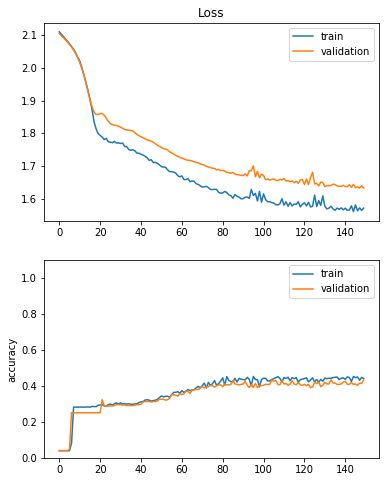

Total time elapsed: 21.4642s


In [304]:
# Train model
t_total = time.time()
train_accuracies, train_losses = [], []
val_accuracies, val_losses = [], []

for t in range(num_epochs):
    train_loss, train_acc, val_loss, val_acc = train_gcn(X_bow,t)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
fig, axs = plt.subplots(2,1, figsize=(6,8))
axs[0].plot(train_losses, label="train")
axs[0].plot(val_losses, label="validation")
axs[0].set_title('Loss')
axs[0].legend(loc='best')

axs[1].plot(train_accuracies, label='train')
axs[1].plot(val_accuracies, label='validation')
axs[1].set_ylim(0, 1.1)
axs[1].set_ylabel("accuracy")
axs[1].legend(loc='best')
plt.show()
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))


In [305]:
# testing
pred = test_gcn(X_bow)  # we have an accuracy of 0% since we compare the results to a dummy label

Test set results: loss= 3.2318 accuracy= 0.0000


In [306]:
_, counts = np.unique(y.detach().numpy(), return_counts=True)
y_pred = torch.exp(pred).detach().numpy()
diff = np.abs(y_pred - counts/len(y))
diff.mean(0)

array([0.02552629, 0.14453198, 0.02864473, 0.21016503, 0.03708264,
       0.01415174, 0.06344451, 0.01516018])

## embedding feature extraction

In [307]:
def get_file_seq(file):
    """
    Function to process a single file.

    ---
    Parameters:
        file : str
                File name in the Data Folder.

    ---
    Results:
        my_data : dict
                Dictionnary containing the number of occurences of each word in
                the document.
    """

    try:
        with open(files_path+'/sequences/'+file+'_seq.pickle', 'rb') as handle:
            file_sequence = pickle.load(handle)
    
    except:        
        
        f = open(files_path + file, "r", encoding="utf-8")
        l = []
        try:
            for x in f:
                x = re.sub(r'[^\w'+"'’ "+']', "",x) #removing all non-alphanumeric characters except apostrophes
                x = x.lower()
                x = x.replace('\n', "")
                x = re.sub(' +', ' ', x) # removing duplicate spaces
                x = x.strip()
                # checking if line is not empty and is in french
                if (x != '' and lid_model.predict(x)[0][0]=='__label__fr'):
                    # lemmatization using spacy
                    doc = nlp(x)
                    tokens = []
                    for token in doc:
                        if token.lemma_.isalnum():
                            tokens.append(token.lemma_)
                    x = ' '.join(tokens)
                    l.append(x)
        except:
            pass
        
        file_sequence = [line.split(' ') for line in l]
        file_sequence = [item for sublist in file_sequence for item in sublist if lid_model.predict(item)[0][0]=='__label__fr']
        file_sequence = [item for item in file_sequence if (len(item) < max_characters and item not in french_stopwords)]
        
        with open(files_path+'/sequences/'+file+'_seq.pickle', 'wb') as handle:
            pickle.dump(file_sequence, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
    
    return file_sequence

In [308]:
def get_sequences(files=['9032']):
    vocab = get_vocab(files=files, pkl=True)
    file_seqs = [get_file_seq(file) for file in files]
    print('got all file sequences, now converting to indexes on vocabulary...')
    word_to_index, index_to_word = {}, []
    for i, w in enumerate(vocab):
        word_to_index[w] = i
        index_to_word.append(w)
    
    sequences = [[word_to_index[w] for w in t if w in word_to_index] for t in file_seqs]
    return sequences

In [309]:
def get_data_seq(path='', dataset='fr-web'):
    
    # Read training data
    with open(path+"train_noduplicates.csv", 'r') as f:
        train_data = f.read().splitlines()

    train_hosts = list()
    y_train = list()
    for row in train_data:
        host, label = row.split(",")
        train_hosts.append(host)
        y_train.append(label.lower())
    
    # Read test data
    with open(path+"test.csv", 'r') as f:
        test_hosts = f.read().splitlines()
        
    idx = train_hosts+test_hosts
    features = get_sequences(files=idx)
    return features

In [310]:
X_seq = get_data_seq()

got all file sequences, now converting to indexes on vocabulary...


In [311]:
seq_lens = [len(s) for s in X_seq]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 1375.5
max length: 45026


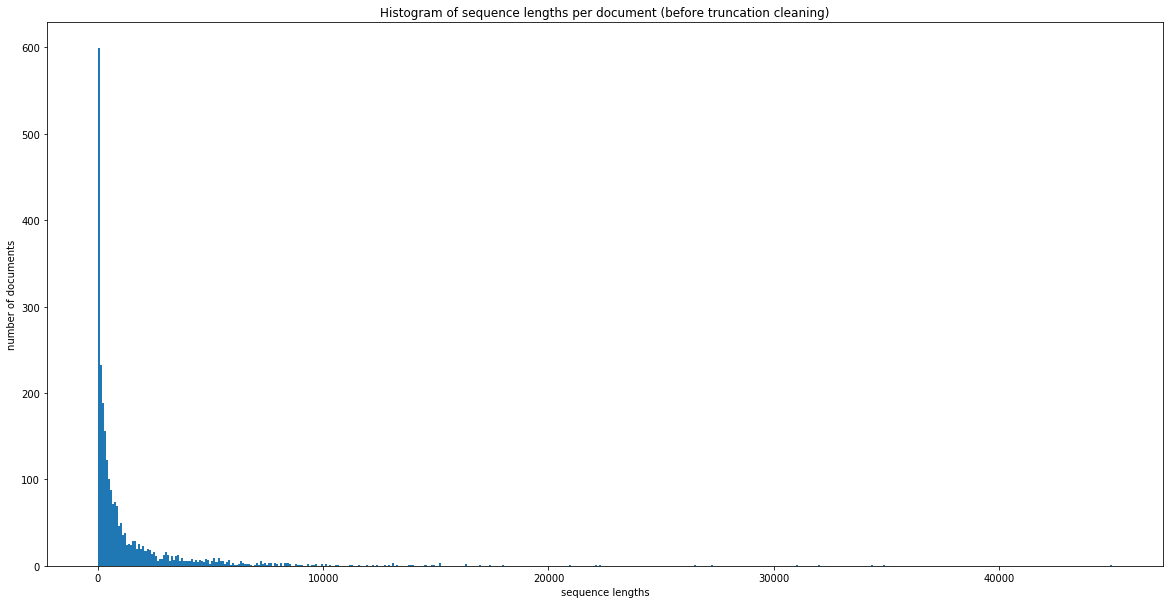

In [371]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.title('Histogram of sequence lengths per document (before truncation cleaning)')
plt.xlabel('sequence lengths')
plt.ylabel('number of documents')
plt.hist(seq_lens, bins=500);

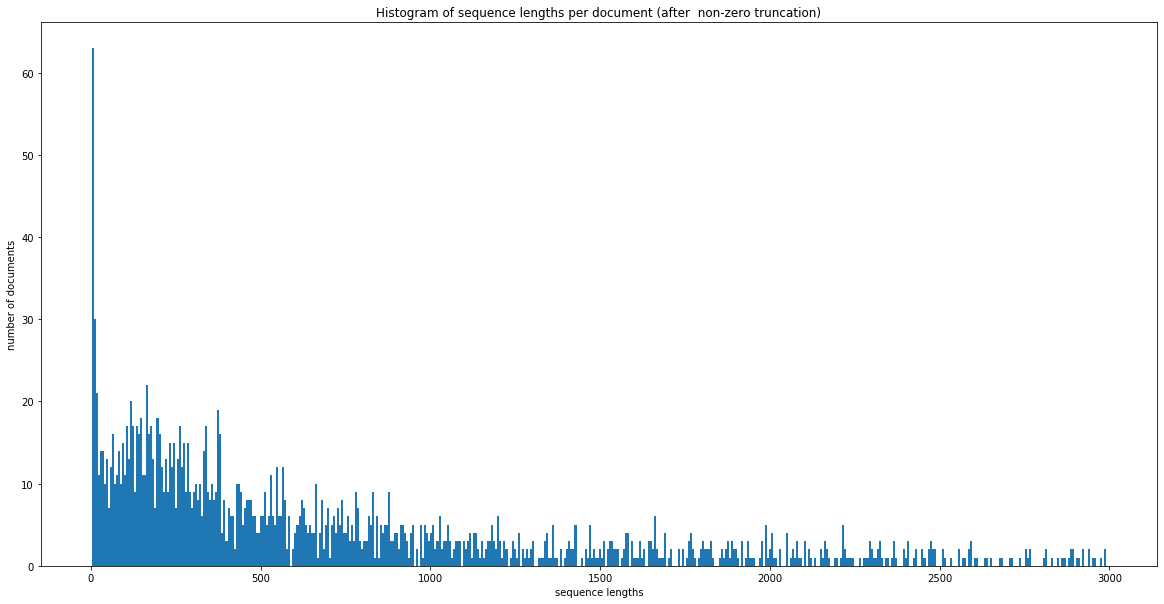

In [372]:
plt.figure(figsize=(20,10))
plt.title('Histogram of sequence lengths per document (after  non-zero truncation)')
plt.xlabel('sequence lengths')
plt.ylabel('number of documents')
plt.hist([l for l in seq_lens if (l < 3000 and l>1)], bins=500);

In [340]:
MAX_SEQUENCE_LENGTH = 1000

feats_train, feats_test, y_train, y_test = train_test_split(X_seq[:1994], y[:1994], 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train = torch.nn.utils.rnn.pad_sequence([torch.Tensor(s).long() for s in feats_train],
                                               batch_first=True)[:,:MAX_SEQUENCE_LENGTH]
X_test = torch.nn.utils.rnn.pad_sequence([torch.Tensor(s).long() for s in feats_test],
                                               batch_first=True)[:,:MAX_SEQUENCE_LENGTH]


print(X_train.shape, X_test.shape)

torch.Size([1595, 1000]) torch.Size([399, 1000])


In [342]:
X_train[3][:10]

tensor([  61,  243,  554,  545, 2717,  211,  974,  712,  211,   51])

In [343]:
train_dataset = data.TensorDataset(X_train, y_train)
test_dataset = data.TensorDataset(X_test, y_test)

In [344]:
def train_epoch(loader, model, loss, optimizer, cuda = False):
    losses, accuracies = 0., 0.
    for batch_idx, (data, target) in enumerate(loader):
        if cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss_value = loss(output, target)
        loss_value.backward()
        optimizer.step()
        acc_value = score(output, target)
        losses += loss_value.item()
        accuracies += acc_value.item()
    batch_idx += 1
    return losses / batch_idx, accuracies / batch_idx
        
def eval_epoch(loader, model, loss):
    losses, accuracies = 0., 0.
    for batch_idx, (data, target) in enumerate(loader):
        if cuda:
            data = data.cuda()
            target = target.cuda()
        output = model(data)
        loss_value = loss(output, target)
        acc_value = score(output, target)
        losses += loss_value.item()
        accuracies += acc_value.item()
    batch_idx += 1
    return losses / batch_idx, accuracies / batch_idx

def train_ann(model, loss, optimizer, batch_size=10, num_epochs=20):

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    train_losses, train_accuracies, test_losses, test_accuracies = [],[],[],[]
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(train_loader, model, loss, optimizer)
        test_loss, test_acc = eval_epoch(test_loader, model, loss)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        print(
            f"epoch {epoch+1} - loss = {train_loss:.2} - train_acc = {train_acc:.2} - test_acc = {test_acc:.2}")
        
    fig, axs = plt.subplots(2,1, figsize=(6,8))
    axs[0].plot(train_losses, label="train")
    axs[0].plot(test_losses, label="test")
    axs[0].set_title('Loss')
    axs[0].legend(loc='best')

    axs[1].plot(train_accuracies, label='train')
    axs[1].plot(test_accuracies, label='test')
    axs[1].set_ylim(0, 1.1)
    axs[1].set_ylabel("accuracy")
    axs[1].legend(loc='best')
    plt.show()

In [345]:
class NeuralNet(nn.Module):
    def __init__(self, vocab_size, emb_dim, n_classes):
        super(NeuralNet, self).__init__()

        self.emb = nn.Embedding(vocab_size,emb_dim)
        self.fc = nn.Linear(emb_dim, n_classes)
        
        
    def forward(self, x):
        x = self.emb(x)
        x = torch.mean(x,1)
        x = self.fc(x)
        return F.log_softmax(x, -1)
    
    def get_layer(self, x):
        x = self.emb(x)
        x = torch.mean(x,1)
        return x

In [346]:
n_classes = len(y_train.unique())
model = NeuralNet(vocab_size, 50, n_classes)
if cuda:
    model = model.cuda()
loss = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters())

epoch 1 - loss = 1.9 - train_acc = 0.28 - test_acc = 0.29
epoch 2 - loss = 1.8 - train_acc = 0.31 - test_acc = 0.33
epoch 3 - loss = 1.8 - train_acc = 0.33 - test_acc = 0.34
epoch 4 - loss = 1.7 - train_acc = 0.35 - test_acc = 0.32
epoch 5 - loss = 1.7 - train_acc = 0.36 - test_acc = 0.38
epoch 6 - loss = 1.7 - train_acc = 0.39 - test_acc = 0.37
epoch 7 - loss = 1.6 - train_acc = 0.41 - test_acc = 0.35
epoch 8 - loss = 1.6 - train_acc = 0.42 - test_acc = 0.36
epoch 9 - loss = 1.6 - train_acc = 0.43 - test_acc = 0.38
epoch 10 - loss = 1.5 - train_acc = 0.44 - test_acc = 0.38
epoch 11 - loss = 1.5 - train_acc = 0.46 - test_acc = 0.38
epoch 12 - loss = 1.5 - train_acc = 0.47 - test_acc = 0.39
epoch 13 - loss = 1.5 - train_acc = 0.47 - test_acc = 0.38
epoch 14 - loss = 1.4 - train_acc = 0.49 - test_acc = 0.42
epoch 15 - loss = 1.4 - train_acc = 0.5 - test_acc = 0.41


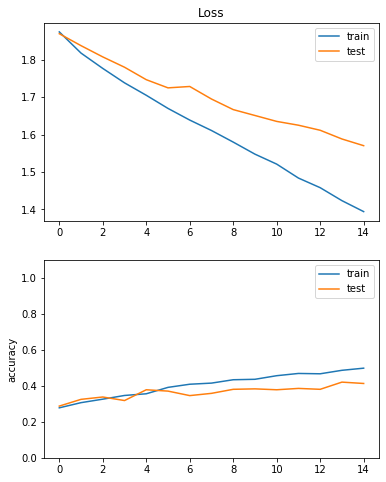

In [319]:
train_ann(model, loss, optimizer, num_epochs=15)

In [320]:
model.eval()
X_seq = get_data_seq()

mlp_feats = torch.nn.utils.rnn.pad_sequence([torch.Tensor(s).long() for s in X_seq],
                                               batch_first=True)[:,:MAX_SEQUENCE_LENGTH]

mlp_feats = model.get_layer(mlp_feats)

got all file sequences, now converting to indexes on vocabulary...


In [321]:
mlp_feats.shape

torch.Size([2554, 50])

In [322]:
n_samples = A_tilde.shape[1]
n_features = mlp_feats.shape[1]

X_gcn = np.zeros((n_samples,n_features))
X_gcn[:mlp_feats.shape[0]] = mlp_feats.detach().numpy()
X_gcn = sp.csr_matrix(X_gcn, dtype=np.float32)
X_gcn = torch.FloatTensor(np.array(X_gcn.todense()))

In [348]:
# Model and optimizer
model = GCN(nfeat=X_gcn.shape[1],
            nhid=hidden,
            nclass=y.max().item() + 1,
            dropout=dropout)
optimizer = optim.Adam(model.parameters(),
                       lr=lr, weight_decay=weight_decay)

In [349]:
if cuda:
    model.cuda()
    X_gcn = X_gcn.cuda()
    A_tilde = A_tilde.cuda()
    y = y.cuda()

Epoch: 0001 loss_train: 2.0666 acc_train: 0.1881 loss_val: 2.0345 acc_val: 0.2055 time: 0.2391s
Epoch: 0002 loss_train: 2.0319 acc_train: 0.2232 loss_val: 1.9930 acc_val: 0.2556 time: 0.1229s
Epoch: 0003 loss_train: 1.9853 acc_train: 0.2364 loss_val: 1.9390 acc_val: 0.2531 time: 0.1076s
Epoch: 0004 loss_train: 1.9257 acc_train: 0.2696 loss_val: 1.8926 acc_val: 0.2882 time: 0.0916s
Epoch: 0005 loss_train: 1.8774 acc_train: 0.2934 loss_val: 1.8917 acc_val: 0.2932 time: 0.0733s
Epoch: 0006 loss_train: 1.8633 acc_train: 0.2834 loss_val: 1.9021 acc_val: 0.2657 time: 0.0604s
Epoch: 0007 loss_train: 1.8732 acc_train: 0.2959 loss_val: 1.8839 acc_val: 0.2481 time: 0.0459s
Epoch: 0008 loss_train: 1.8508 acc_train: 0.2934 loss_val: 1.8568 acc_val: 0.2431 time: 0.0590s
Epoch: 0009 loss_train: 1.8214 acc_train: 0.3210 loss_val: 1.8382 acc_val: 0.2556 time: 0.0428s
Epoch: 0010 loss_train: 1.8067 acc_train: 0.3135 loss_val: 1.8255 acc_val: 0.2882 time: 0.0462s
Epoch: 0011 loss_train: 1.7861 acc_train

Epoch: 0088 loss_train: 1.5125 acc_train: 0.4401 loss_val: 1.5862 acc_val: 0.4185 time: 0.0454s
Epoch: 0089 loss_train: 1.5066 acc_train: 0.4476 loss_val: 1.5795 acc_val: 0.4261 time: 0.0548s
Epoch: 0090 loss_train: 1.5180 acc_train: 0.4495 loss_val: 1.5835 acc_val: 0.4160 time: 0.0513s
Epoch: 0091 loss_train: 1.5003 acc_train: 0.4539 loss_val: 1.5811 acc_val: 0.4361 time: 0.0366s
Epoch: 0092 loss_train: 1.5036 acc_train: 0.4646 loss_val: 1.5806 acc_val: 0.4336 time: 0.0377s
Epoch: 0093 loss_train: 1.5010 acc_train: 0.4596 loss_val: 1.5793 acc_val: 0.4261 time: 0.0445s
Epoch: 0094 loss_train: 1.5031 acc_train: 0.4508 loss_val: 1.5793 acc_val: 0.4236 time: 0.0693s
Epoch: 0095 loss_train: 1.4976 acc_train: 0.4614 loss_val: 1.5790 acc_val: 0.4311 time: 0.0738s
Epoch: 0096 loss_train: 1.4895 acc_train: 0.4589 loss_val: 1.5787 acc_val: 0.4211 time: 0.1244s
Epoch: 0097 loss_train: 1.4975 acc_train: 0.4577 loss_val: 1.5794 acc_val: 0.4336 time: 0.0884s
Epoch: 0098 loss_train: 1.4914 acc_train

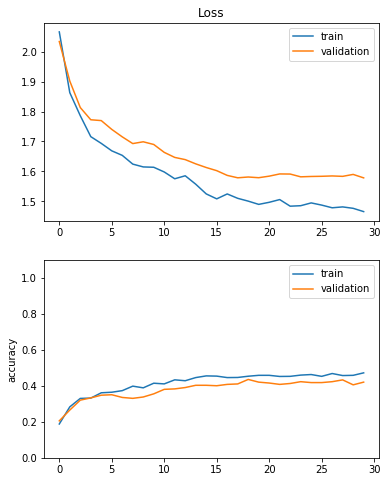

Total time elapsed: 9.8197s


In [350]:
# Train model
t_total = time.time()
train_accuracies, train_losses = [], []
val_accuracies, val_losses = [], []

for t in range(num_epochs):
    train_loss, train_acc, val_loss, val_acc = train_gcn(X_gcn,t)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
fig, axs = plt.subplots(2,1, figsize=(6,8))
axs[0].plot(train_losses[::5], label="train")
axs[0].plot(val_losses[::5], label="validation")
axs[0].set_title('Loss')
axs[0].legend(loc='best')

axs[1].plot(train_accuracies[::5], label='train')
axs[1].plot(val_accuracies[::5], label='validation')
axs[1].set_ylim(0, 1.1)
axs[1].set_ylabel("accuracy")
axs[1].legend(loc='best')
plt.show()
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

## training a ConvLSTM model and using its features

In [291]:
class ConvLSTM(nn.Module):
    """
    - conv1d - relu - maxpooling
    - conv1d - relu - maxpooling
    - lstm
    - fully connected
    """
    def __init__(self, vocab_size, emb_dim, n_classes):
        super(ConvLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.conv1 = nn.Conv1d(emb_dim, emb_dim, 5)
        self.conv2 = nn.Conv1d(emb_dim, emb_dim, 5)
        self.lstm = nn.LSTM(emb_dim, emb_dim)
        self.fc = nn.Linear(emb_dim, n_classes)
        # TODO
    
    def forward(self, x):
        # TODO
        x = self.embedding(x)
        x = x.transpose(1,2)
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool1d(x, kernel_size=5)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool1d(x, kernel_size=5) # batch_size x emb_dim x len
        x = x.transpose(0,1) #  emb_dim x batch_size x len
        x = x.transpose(0,2)
        x, _ = self.lstm(x)
        x = x[-1]
        x = self.fc(x)
        return F.log_softmax(x, -1)
    
    def get_layer(self, x):
        x = self.embedding(x)
        x = x.transpose(1,2)
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool1d(x, kernel_size=5)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool1d(x, kernel_size=5) # batch_size x emb_dim x len
        x = x.transpose(0,1) #  emb_dim x batch_size x len
        x = x.transpose(0,2)
        x, _ = self.lstm(x)
        x = x[-1]
        return x

In [292]:
model = ConvLSTM(vocab_size, 50, n_classes)
if cuda:
    model = model.cuda()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

epoch 1 - loss = 1.8 - train_acc = 0.3 - test_acc = 0.24
epoch 2 - loss = 1.8 - train_acc = 0.29 - test_acc = 0.28
epoch 3 - loss = 1.7 - train_acc = 0.31 - test_acc = 0.26
epoch 4 - loss = 1.7 - train_acc = 0.33 - test_acc = 0.28
epoch 5 - loss = 1.6 - train_acc = 0.39 - test_acc = 0.28


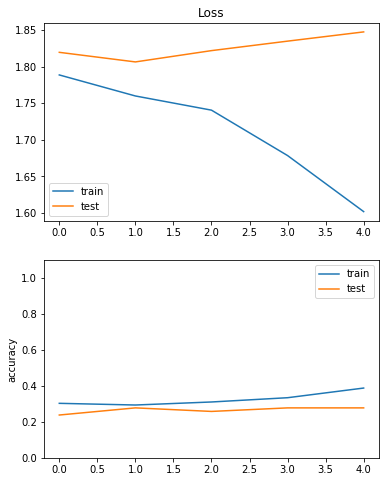

In [293]:
train_ann(model, loss, optimizer, num_epochs=5)

In [294]:
model.eval()
X_seq = get_data_seq()

conv_feats = torch.nn.utils.rnn.pad_sequence([torch.Tensor(s).long() for s in X_seq],
                                               batch_first=True)[:,:MAX_SEQUENCE_LENGTH]

conv_feats = model.get_layer(conv_feats)

got all file sequences, now converting to indexes on vocabulary...


In [295]:
conv_feats.shape

torch.Size([2554, 50])

In [296]:
n_samples = A_tilde.shape[1]
n_features = conv_feats.shape[1]

X_conv = np.zeros((n_samples,n_features))
X_conv[:conv_feats.shape[0]] = conv_feats.detach().numpy()
X_conv = sp.csr_matrix(X_conv, dtype=np.float32)
X_conv = torch.FloatTensor(np.array(X_conv.todense()))

In [297]:
# Model and optimizer
model = GCN(nfeat=X_conv.shape[1],
            nhid=hidden,
            nclass=y.max().item() + 1,
            dropout=dropout)
optimizer = optim.Adam(model.parameters(),
                       lr=lr, weight_decay=weight_decay)

In [ ]:
if cuda:
    model.cuda()
    X_conv = X_conv.cuda()
    A_tilde = A_tilde.cuda()
    y = y.cuda()

Epoch: 0001 loss_train: 2.1470 acc_train: 0.0752 loss_val: 2.0610 acc_val: 0.1579 time: 0.0532s
Epoch: 0002 loss_train: 2.0754 acc_train: 0.1141 loss_val: 2.0282 acc_val: 0.1554 time: 0.0749s
Epoch: 0003 loss_train: 2.0403 acc_train: 0.1260 loss_val: 1.9984 acc_val: 0.1629 time: 0.0587s
Epoch: 0004 loss_train: 2.0074 acc_train: 0.1367 loss_val: 1.9632 acc_val: 0.1729 time: 0.0429s
Epoch: 0005 loss_train: 1.9682 acc_train: 0.1856 loss_val: 1.9222 acc_val: 0.2506 time: 0.0474s
Epoch: 0006 loss_train: 1.9378 acc_train: 0.2082 loss_val: 1.8772 acc_val: 0.2381 time: 0.0450s
Epoch: 0007 loss_train: 1.8929 acc_train: 0.2752 loss_val: 1.8338 acc_val: 0.2381 time: 0.0500s
Epoch: 0008 loss_train: 1.8386 acc_train: 0.3147 loss_val: 1.8054 acc_val: 0.2381 time: 0.0430s
Epoch: 0009 loss_train: 1.8075 acc_train: 0.2903 loss_val: 1.8102 acc_val: 0.2381 time: 0.0314s
Epoch: 0010 loss_train: 1.8149 acc_train: 0.2834 loss_val: 1.8353 acc_val: 0.2381 time: 0.0376s
Epoch: 0011 loss_train: 1.8393 acc_train

Epoch: 0087 loss_train: 1.6818 acc_train: 0.3893 loss_val: 1.7365 acc_val: 0.3233 time: 0.0481s
Epoch: 0088 loss_train: 1.6835 acc_train: 0.3774 loss_val: 1.7352 acc_val: 0.3183 time: 0.0477s
Epoch: 0089 loss_train: 1.6636 acc_train: 0.3837 loss_val: 1.7331 acc_val: 0.3158 time: 0.0653s
Epoch: 0090 loss_train: 1.6719 acc_train: 0.3818 loss_val: 1.7306 acc_val: 0.3208 time: 0.0627s
Epoch: 0091 loss_train: 1.6783 acc_train: 0.3824 loss_val: 1.7298 acc_val: 0.3183 time: 0.1035s
Epoch: 0092 loss_train: 1.6655 acc_train: 0.3762 loss_val: 1.7305 acc_val: 0.3233 time: 0.0533s
Epoch: 0093 loss_train: 1.6785 acc_train: 0.3724 loss_val: 1.7309 acc_val: 0.3108 time: 0.0437s
Epoch: 0094 loss_train: 1.6624 acc_train: 0.3705 loss_val: 1.7303 acc_val: 0.3108 time: 0.0392s
Epoch: 0095 loss_train: 1.6789 acc_train: 0.3630 loss_val: 1.7271 acc_val: 0.3133 time: 0.0376s
Epoch: 0096 loss_train: 1.6732 acc_train: 0.3781 loss_val: 1.7244 acc_val: 0.3108 time: 0.0451s
Epoch: 0097 loss_train: 1.6728 acc_train

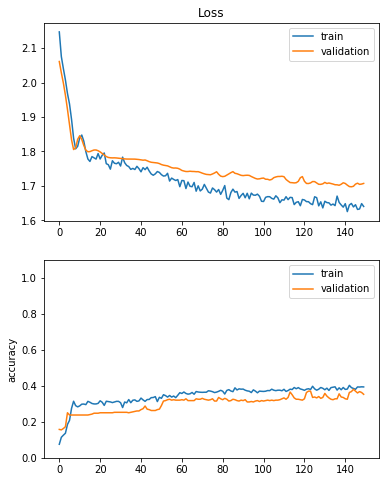

Total time elapsed: 8.7647s


In [299]:
# Train model
t_total = time.time()
train_accuracies, train_losses = [], []
val_accuracies, val_losses = [], []

for t in range(num_epochs):
    train_loss, train_acc, val_loss, val_acc = train_gcn(X_conv,t)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
fig, axs = plt.subplots(2,1, figsize=(6,8))
axs[0].plot(train_losses[::5], label="train")
axs[0].plot(val_losses[::5], label="validation")
axs[0].set_title('Loss')
axs[0].legend(loc='best')

axs[1].plot(train_accuracies[::5], label='train')
axs[1].plot(val_accuracies[::5], label='validation')
axs[1].set_ylim(0, 1.1)
axs[1].set_ylabel("accuracy")
axs[1].legend(loc='best')
plt.show()
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

## using tf-idf features as an input to GCN model

In [351]:
def get_tfidf():    
    # Read training data
    with open("train_noduplicates.csv", 'r') as f:
        train_data = f.read().splitlines()

    train_hosts = list()
    y_train = list()
    for row in train_data:
        host, label = row.split(",")
        train_hosts.append(host)
        y_train.append(label.lower())

    # Read test data
    with open("test.csv", 'r') as f:
        test_hosts = f.read().splitlines()
        
    
    idx = train_hosts+test_hosts
    
    # Load the textual content of a set of webpages for each host into the dictionary "text". 
    # The encoding parameter is required since the majority of our text is french.
    text = dict()
    filenames = os.listdir('text/text')
    for filename in idx:
        try:
            with codecs.open(path.join('text/text/', filename), encoding='latin-1') as f: 
                text[filename] = f.read().replace("\n", " ").lower()
        except:
            pass
        
    data = list()
    for host in idx:
        if host in text:
            data.append(text[host])
        else:
            data.append('')   

    vec = TfidfVectorizer(decode_error='ignore', strip_accents='unicode', encoding='latin-1', min_df=10, max_df=1000)
    features = vec.fit_transform(data)
    
    features = torch.FloatTensor(np.array(features.todense()))
    return features

In [352]:
tfidf_feats = get_tfidf()

In [353]:
n_samples = A_tilde.shape[1]
n_features = tfidf_feats.shape[1]

X_tfidf = np.zeros((n_samples,n_features))
X_tfidf[:tfidf_feats.shape[0]] = tfidf_feats.detach().numpy()
X_tfidf = sp.csr_matrix(X_tfidf, dtype=np.float32)
X_tfidf = torch.FloatTensor(np.array(X_tfidf.todense()))

In [354]:
# Model and optimizer
model = GCN(nfeat=X_tfidf.shape[1],
            nhid=hidden,
            nclass=y.max().item() + 1,
            dropout=dropout)
optimizer = optim.Adam(model.parameters(),
                       lr=lr, weight_decay=weight_decay)

In [355]:
if cuda:
    model.cuda()
    X_tfidf = X_tfidf.cuda()
    A_tilde = A_tilde.cuda()
    y = y.cuda()
else:
    A_tilde = A_tilde.cpu()
    y = y.cpu()

Epoch: 0001 loss_train: 2.1128 acc_train: 0.1273 loss_val: 2.0999 acc_val: 0.1303 time: 0.3900s
Epoch: 0002 loss_train: 2.0977 acc_train: 0.1285 loss_val: 2.0860 acc_val: 0.1303 time: 0.2221s
Epoch: 0003 loss_train: 2.0826 acc_train: 0.1285 loss_val: 2.0674 acc_val: 0.1303 time: 0.4836s
Epoch: 0004 loss_train: 2.0606 acc_train: 0.1285 loss_val: 2.0384 acc_val: 0.1328 time: 0.4272s
Epoch: 0005 loss_train: 2.0313 acc_train: 0.1455 loss_val: 1.9920 acc_val: 0.3083 time: 0.4019s
Epoch: 0006 loss_train: 1.9810 acc_train: 0.3028 loss_val: 1.9290 acc_val: 0.3333 time: 0.2047s
Epoch: 0007 loss_train: 1.9069 acc_train: 0.3304 loss_val: 1.8648 acc_val: 0.3008 time: 0.2556s
Epoch: 0008 loss_train: 1.8446 acc_train: 0.3103 loss_val: 1.8330 acc_val: 0.2857 time: 0.2464s
Epoch: 0009 loss_train: 1.7969 acc_train: 0.3172 loss_val: 1.8462 acc_val: 0.2932 time: 0.2537s
Epoch: 0010 loss_train: 1.8088 acc_train: 0.3204 loss_val: 1.8426 acc_val: 0.3308 time: 0.2714s
Epoch: 0011 loss_train: 1.8230 acc_train

Epoch: 0087 loss_train: 1.0492 acc_train: 0.6420 loss_val: 1.7232 acc_val: 0.4286 time: 0.2836s
Epoch: 0088 loss_train: 1.0593 acc_train: 0.6320 loss_val: 1.6911 acc_val: 0.4336 time: 0.2415s
Epoch: 0089 loss_train: 1.0123 acc_train: 0.6502 loss_val: 1.6818 acc_val: 0.4411 time: 0.2658s
Epoch: 0090 loss_train: 1.0493 acc_train: 0.6495 loss_val: 1.7091 acc_val: 0.4436 time: 0.2417s
Epoch: 0091 loss_train: 1.0298 acc_train: 0.6502 loss_val: 1.7776 acc_val: 0.4361 time: 0.3465s
Epoch: 0092 loss_train: 1.0345 acc_train: 0.6357 loss_val: 1.7507 acc_val: 0.4336 time: 0.2579s
Epoch: 0093 loss_train: 1.0359 acc_train: 0.6502 loss_val: 1.7259 acc_val: 0.4311 time: 0.3278s
Epoch: 0094 loss_train: 1.0352 acc_train: 0.6539 loss_val: 1.7035 acc_val: 0.4436 time: 0.2829s
Epoch: 0095 loss_train: 1.0222 acc_train: 0.6326 loss_val: 1.7226 acc_val: 0.4436 time: 0.2454s
Epoch: 0096 loss_train: 1.0256 acc_train: 0.6483 loss_val: 1.7658 acc_val: 0.4286 time: 0.2883s
Epoch: 0097 loss_train: 1.0468 acc_train

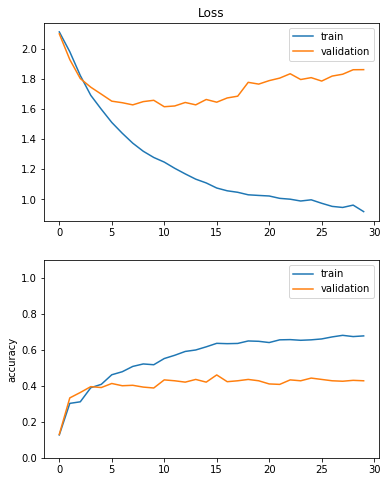

Total time elapsed: 46.6122s


In [357]:
# Train model
t_total = time.time()
train_accuracies, train_losses = [], []
val_accuracies, val_losses = [], []

for t in range(num_epochs):
    train_loss, train_acc, val_loss, val_acc = train_gcn(X_tfidf,t)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
fig, axs = plt.subplots(2,1, figsize=(6,8))
axs[0].plot(train_losses[::5], label="train")
axs[0].plot(val_losses[::5], label="validation")
axs[0].set_title('Loss')
axs[0].legend(loc='best')

axs[1].plot(train_accuracies[::5], label='train')
axs[1].plot(val_accuracies[::5], label='validation')
axs[1].set_ylim(0, 1.1)
axs[1].set_ylabel("accuracy")
axs[1].legend(loc='best')
plt.show()
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

In [358]:
# testing
pred = test_gcn(X_tfidf)  # we have an accuracy of 0% since we compare the results to a dummy label

Test set results: loss= 4.9585 accuracy= 0.0000


In [359]:
y_pred = torch.exp(pred).detach().numpy()

In [360]:
# Write predictions to a file
with open('tfidf_gcn.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = classes
    lst.insert(0, "Host")
    writer.writerow(lst)
    with open("test.csv", 'r') as f:
        test_hosts = f.read().splitlines()
    for i,test_host in enumerate(test_hosts):
        lst = y_pred[i,:].tolist()
        lst.insert(0, test_host)
        writer.writerow(lst)

## pre-trained model

In [398]:
X_bert = np.array(pd.read_csv('train_camembert.csv'))
X_bert[0].shape

(768,)

In [399]:
X_bert = sp.csr_matrix(X_bert, dtype=np.float32)
X_bert = torch.FloatTensor(np.array(X_bert.todense()))

In [400]:
# Model and optimizer
model = GCN(nfeat=X_bert.shape[1],
            nhid=hidden,
            nclass=y.max().item() + 1,
            dropout=dropout)
optimizer = optim.Adam(model.parameters(),
                       lr=lr, weight_decay=weight_decay)

In [401]:
if cuda:
    model.cuda()
    X_tfidf = X_bert.cuda()
    A_tilde = A_tilde.cuda()
    y = y.cuda()
else:
    A_tilde = A_tilde.cpu()
    y = y.cpu()

Epoch: 0001 loss_train: 2.0269 acc_train: 0.2890 loss_val: 1.9515 acc_val: 0.2932 time: 0.1515s
Epoch: 0002 loss_train: 1.9322 acc_train: 0.3009 loss_val: 1.8778 acc_val: 0.2456 time: 0.0843s
Epoch: 0003 loss_train: 1.8565 acc_train: 0.2915 loss_val: 1.8950 acc_val: 0.2506 time: 0.0606s
Epoch: 0004 loss_train: 1.8401 acc_train: 0.2828 loss_val: 1.8936 acc_val: 0.2456 time: 0.0526s
Epoch: 0005 loss_train: 1.8602 acc_train: 0.2740 loss_val: 1.8493 acc_val: 0.2957 time: 0.0619s
Epoch: 0006 loss_train: 1.8111 acc_train: 0.3022 loss_val: 1.8296 acc_val: 0.2506 time: 0.0644s
Epoch: 0007 loss_train: 1.8160 acc_train: 0.2777 loss_val: 1.8320 acc_val: 0.2957 time: 0.0551s
Epoch: 0008 loss_train: 1.8066 acc_train: 0.2928 loss_val: 1.8366 acc_val: 0.2932 time: 0.0510s
Epoch: 0009 loss_train: 1.8156 acc_train: 0.2897 loss_val: 1.8341 acc_val: 0.2932 time: 0.0472s
Epoch: 0010 loss_train: 1.8233 acc_train: 0.2890 loss_val: 1.8266 acc_val: 0.2882 time: 0.0650s
Epoch: 0011 loss_train: 1.8021 acc_train

Epoch: 0089 loss_train: 1.6046 acc_train: 0.3862 loss_val: 1.6338 acc_val: 0.3985 time: 0.0555s
Epoch: 0090 loss_train: 1.6602 acc_train: 0.3404 loss_val: 1.6602 acc_val: 0.3659 time: 0.0682s
Epoch: 0091 loss_train: 1.6233 acc_train: 0.3680 loss_val: 1.6958 acc_val: 0.3584 time: 0.0976s
Epoch: 0092 loss_train: 1.6494 acc_train: 0.3668 loss_val: 1.6457 acc_val: 0.3684 time: 0.1186s
Epoch: 0093 loss_train: 1.6169 acc_train: 0.3699 loss_val: 1.6645 acc_val: 0.3484 time: 0.0826s
Epoch: 0094 loss_train: 1.6381 acc_train: 0.3699 loss_val: 1.6333 acc_val: 0.3584 time: 0.0714s
Epoch: 0095 loss_train: 1.6134 acc_train: 0.3755 loss_val: 1.6877 acc_val: 0.3459 time: 0.0470s
Epoch: 0096 loss_train: 1.6694 acc_train: 0.3630 loss_val: 1.6269 acc_val: 0.3734 time: 0.0627s
Epoch: 0097 loss_train: 1.6065 acc_train: 0.3893 loss_val: 1.6841 acc_val: 0.4035 time: 0.0660s
Epoch: 0098 loss_train: 1.6931 acc_train: 0.3492 loss_val: 1.6401 acc_val: 0.3935 time: 0.0469s
Epoch: 0099 loss_train: 1.6197 acc_train

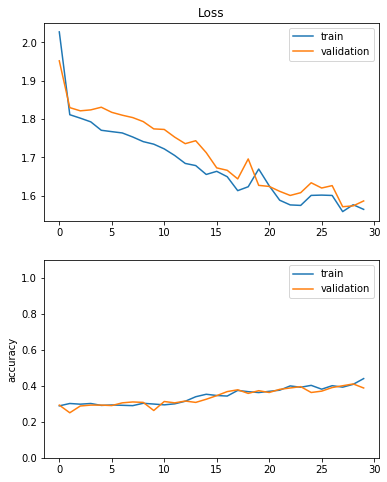

Total time elapsed: 12.1165s


In [402]:
# Train model
t_total = time.time()
train_accuracies, train_losses = [], []
val_accuracies, val_losses = [], []

for t in range(num_epochs):
    train_loss, train_acc, val_loss, val_acc = train_gcn(X_bert,t)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
fig, axs = plt.subplots(2,1, figsize=(6,8))
axs[0].plot(train_losses[::5], label="train")
axs[0].plot(val_losses[::5], label="validation")
axs[0].set_title('Loss')
axs[0].legend(loc='best')

axs[1].plot(train_accuracies[::5], label='train')
axs[1].plot(val_accuracies[::5], label='validation')
axs[1].set_ylim(0, 1.1)
axs[1].set_ylabel("accuracy")
axs[1].legend(loc='best')
plt.show()
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))